In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

In [2]:
mypath="C://Users//ivana//OneDrive//Desktop//Fall Semester//Python"
file='tripadvisor.csv'
os.chdir(mypath)
data = pd.read_csv(file,encoding = "ISO-8859-1")
# Drop missing values if any
data=data.dropna()

In [3]:
# Variables are Review and Rating. Goal is to predict Rating for a new review using naive Bayes
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,unique \tgreat stay \twonderful time hotel mon...,5
4,great stay great stay \twent seahawk game awes...,5
...,...,...
20486,best kept secret 3rd time staying charm \tnot ...,5
20487,great location price view hotel great quick pl...,4
20488,ok just looks nice modern outside \tdesk staff...,2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
# Seems like a solid sample - almost 20.5k observations
data.describe() 

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [5]:
# Most of the reviews are 4-5 stars, it might affect predicting power
data.groupby('Rating').describe() 

Review                                                               
        count unique                                                top freq
Rating                                                                      
1        1421   1421  checked immediately checked \ttour pacific nor...    1
2        1793   1793  rooms tiny \ttravel agent booked hotel trade e...    1
3        2184   2184  great location poor service husband just got i...    1
4        6039   6039  paid travel 2 kids 2 4 got upgraded executive ...    1
5        9054   9054  great location/hotel stayed night post-cruise ...    1

In [6]:
# Text seems to be semi-processed already
data['Review'][0] 

'nice hotel expensive parking got good deal stay hotel anniversary \tarrived late evening took advice previous reviews did valet parking \tcheck quick easy \tlittle disappointed non-existent view room room clean nice size \tbed comfortable woke stiff neck high pillows \tnot soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway \tmaybe just noisy neighbors \taveda bath products nice \tdid not goldfish stay nice touch taken advantage staying longer \tlocation great walking distance shopping \toverall nice experience having pay 40 parking night \t '

In [7]:
new=[]# \t will be removed
for i in list(data['Review']):
    i = i.replace('\t',' ')
    i = i.replace('   ',' ')
    i = i.replace('  ',' ')
    new.append(i)
data['Review'] = pd.DataFrame({'Review':new})

In [9]:
# Looks cleaner
data['Review'][0]

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed non-existent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay 40 parking night '

In [11]:
# Adding the length of reviews as a variable
data['Length'] = data['Review'].apply(len) 
data

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,581
1,ok nothing special charge diamond member hilto...,2,1668
2,nice rooms not 4* experience hotel monaco seat...,3,1410
3,unique great stay wonderful time hotel monaco ...,5,586
4,great stay great stay went seahawk game awesom...,5,1247
...,...,...,...
20486,best kept secret 3rd time staying charm not 5-...,5,720
20487,great location price view hotel great quick pl...,4,304
20488,ok just looks nice modern outside desk staff n...,2,435
20489,hotel theft ruined vacation hotel opened sept ...,1,5501


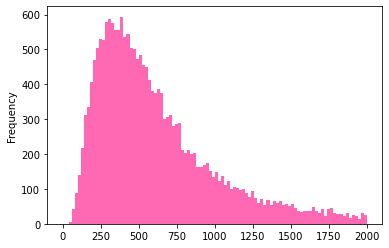

In [12]:
# Checking the overall distribution
data['Length'].plot(bins=100, kind='hist', color='hotpink',range=[0,2000]) 

In [13]:
data.sort_values(by = "Rating")

,Review,Rating,Length
11578,not good checked asked room track said dollars...,1,421
17628,terrible service ignorant staff reading great ...,1,523
11551,disappointing experience stayed oriente reccom...,1,492
6595,terrible place stay family miami fl plus coupl...,1,1645
2109,fawlty towers usa style sister property 215 w....,1,407
...,...,...,...
13328,fabulous hotel husband stayed hotel luxembourg...,5,539
13329,helpful desk good hotel quite convenient spot ...,5,163
13330,came nonexistent view loved really enjoyed sta...,5,1500
5162,hotel ares booked trawling trip advisor bookin...,5,745


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024664425250>,
      dtype=object)

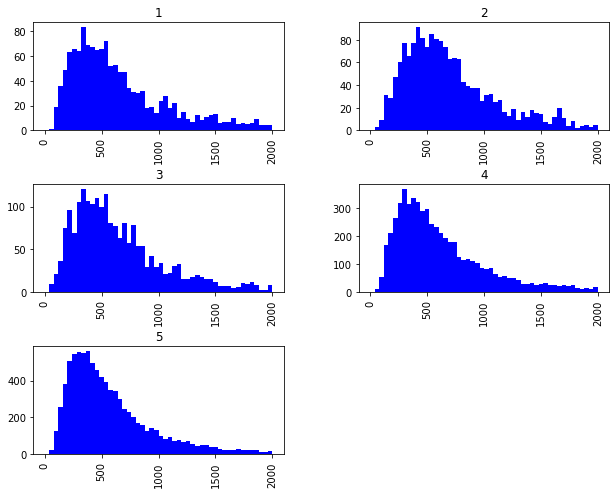

In [14]:
# Checking the distribution for each star rating to see if there are significant differences
# For example, maybe bad reviews could be shorter beucase people don't want to spend time on
# giving feedback for something they didn't like
one_star = data[data['Rating']==1]
two_star= data[data['Rating']==2] 
three_star= data[data['Rating']==3]
four_star= data[data['Rating']==4] 
five_star= data[data['Rating']==5]
data.hist(column='Length', by='Rating',color='blue', bins=50, figsize=(10,8), range=[0, 2000])

In [15]:
# Finalizing the cleaning, numbers are removed because they don't seem to contribute towards predictions
new=[] 
for i in list(data['Review']):        
    i = i.replace('.',' ')
    i = i.replace('*',' ')
    i = i.replace('/',' ')
    i = i.replace('_',' ')
    i = i.replace('-',' ')
    i = i.replace("'","")
    i=''.join(letter for letter in i if not letter.isdigit())
    i=' '.join([word for word in i.split() if len(word)>1])
    new.append(i)
data['Review'] = pd.DataFrame({'Review':new})

In [16]:
 # Data is now ready
list(data['Review'])

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay parking night',
 'ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description not suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls suit

In [17]:
# Redefining after cleaning
one_star = data[data['Rating']==1] 
two_star= data[data['Rating']==2]
three_star= data[data['Rating']==3]
four_star= data[data['Rating']==4]
five_star= data[data['Rating']==5]

words=[]
for i in list(one_star['Review']):
    words.extend(i.split())
one_star_review=words
words=[]
for i in list(two_star['Review']):
    words.extend(i.split())
two_star_review=words
words=[]
for i in list(three_star['Review']):
    words.extend(i.split())
three_star_review=words
words=[]
for i in list(four_star['Review']):
    words.extend(i.split())
four_star_review=words
words=[]
for i in list(five_star['Review']):
    words.extend(i.split())
five_star_review=words

# List of all words in each rating category with their frequencies
# I would like to see what are the key words for every rating
dict_one = Counter(one_star_review) 
dict_two=Counter(two_star_review)   
dict_three=Counter(three_star_review)
dict_four=Counter(four_star_review)
dict_five=Counter(five_star_review)

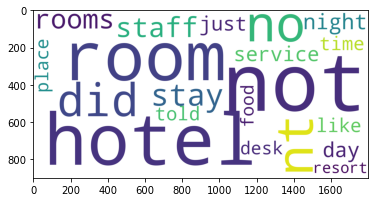

In [18]:
wc = WordCloud(width=1800, height=900, background_color="white",
               max_words = 20, relative_scaling = 0.5, 
               normalize_plurals = False).generate_from_frequencies(dict_one)
#Just visualising, it seems like NOT, NO, NT are quite common for low rated reviews
plt.imshow(wc) 

([<matplotlib.axis.XTick at 0x246701bdac0>,
 [Text(0, 0, 'not'),
  Text(0, 0, 'hotel'),
  Text(0, 0, 'room'),
  Text(0, 0, 'nt'),
  Text(0, 0, 'no'),
  Text(0, 0, 'did'),
  Text(0, 0, 'stay'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'rooms'),
  Text(0, 0, 'night')])

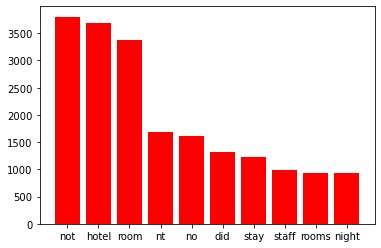

In [19]:
labels, values = zip(*dict_one.items()) # This is more precise
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="red")
plt.xticks(indexes,labels)

In [20]:
one_mod=[word for word in one_star_review if word not in ['hotel','room','rooms','stay','did']]
two_mod=[word for word in two_star_review if word not in ['hotel','room','rooms','stay','did']]
three_mod=[word for word in three_star_review if word not in ['hotel','room','rooms','stay','did']]
four_mod=[word for word in four_star_review if word not in ['hotel','room','rooms','stay','did']]
five_mod=[word for word in five_star_review if word not in ['hotel','room','rooms','stay','did']]
# HOTEL and ROOM are frequent in all reviews so I decided to remove them to allow more relevant
# words to stand out
dict_one = Counter(one_mod)   
dict_two=Counter(two_mod)     
dict_three=Counter(three_mod) 
dict_four=Counter(four_mod) 
dict_five=Counter(five_mod)

([<matplotlib.axis.XTick at 0x24663947d00>,
 [Text(0, 0, 'not'),
  Text(0, 0, 'nt'),
  Text(0, 0, 'no'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'night'),
  Text(0, 0, 'day'),
  Text(0, 0, 'service'),
  Text(0, 0, 'just'),
  Text(0, 0, 'like'),
  Text(0, 0, 'told')])

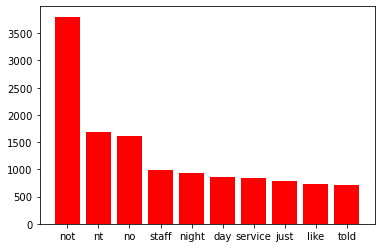

In [21]:
labels, values = zip(*dict_one.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="red")
plt.xticks(indexes,labels)

([<matplotlib.axis.XTick at 0x246659ea6a0>,
 [Text(0, 0, 'not'),
  Text(0, 0, 'nt'),
  Text(0, 0, 'no'),
  Text(0, 0, 'good'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'just'),
  Text(0, 0, 'service'),
  Text(0, 0, 'night'),
  Text(0, 0, 'food'),
  Text(0, 0, 'day')])

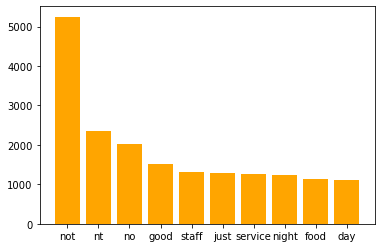

In [22]:
labels, values = zip(*dict_two.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="orange")
plt.xticks(indexes,labels)

([<matplotlib.axis.XTick at 0x24665a66cd0>,
 [Text(0, 0, 'not'),
  Text(0, 0, 'nt'),
  Text(0, 0, 'good'),
  Text(0, 0, 'nice'),
  Text(0, 0, 'great'),
  Text(0, 0, 'no'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'just'),
  Text(0, 0, 'location'),
  Text(0, 0, 'beach')])

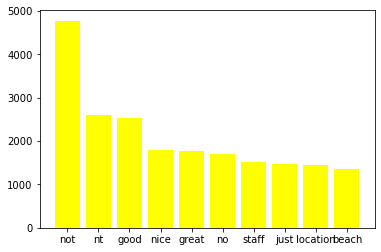

In [23]:
labels, values = zip(*dict_three.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="yellow")
plt.xticks(indexes,labels)

([<matplotlib.axis.XTick at 0x2466593a100>,
 [Text(0, 0, 'not'),
  Text(0, 0, 'great'),
  Text(0, 0, 'good'),
  Text(0, 0, 'nt'),
  Text(0, 0, 'nice'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'location'),
  Text(0, 0, 'just'),
  Text(0, 0, 'beach'),
  Text(0, 0, 'clean')])

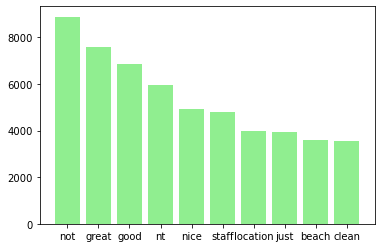

In [24]:
# In the better reviews words GREAT, NICE started to stand out
labels, values = zip(*dict_four.items())  
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="lightgreen")
plt.xticks(indexes,labels)

([<matplotlib.axis.XTick at 0x2467018baf0>,
 [Text(0, 0, 'great'),
  Text(0, 0, 'not'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'nt'),
  Text(0, 0, 'good'),
  Text(0, 0, 'just'),
  Text(0, 0, 'location'),
  Text(0, 0, 'stayed'),
  Text(0, 0, 'nice'),
  Text(0, 0, 'breakfast')])

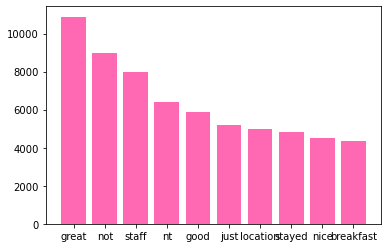

In [25]:
# It is kind of interesting that NOT stays dominant as the ratings improve Hmmm!
labels, values = zip(*dict_five.items()) 
indSort = np.argsort(values)[::-1]       
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="hotpink")
plt.xticks(indexes,labels)

([<matplotlib.axis.XTick at 0x24675a7bfa0>,
 [Text(0, 0, 'no'),
  Text(0, 0, 'staff'),
  Text(0, 0, 'night'),
  Text(0, 0, 'day'),
  Text(0, 0, 'service'),
  Text(0, 0, 'just'),
  Text(0, 0, 'like'),
  Text(0, 0, 'told'),
  Text(0, 0, 'time'),
  Text(0, 0, 'place')])

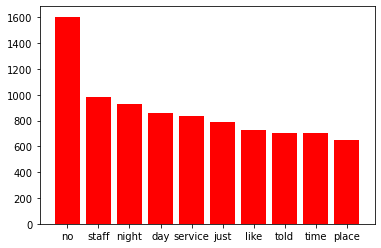

In [44]:
# NO seems to be decreasing when rating increases - could be a solid predictor
one=dict_one
del one['not'] 
del one['nt']
labels, values = zip(*one.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort][0:10]
values = np.array(values)[indSort][0:10]
indexes = np.arange(len(labels))
plt.bar(indexes, values, color="red")
plt.xticks(indexes,labels)

In [26]:
# NAIVE BAYES
review_train, review_test, rating_train, rating_test = train_test_split(data['Review'], data['Rating'],
                                                                        test_size=0.2, random_state=1)

In [27]:
TfidfVectorizer().fit_transform(list(data['Review']))

<20491x49295 sparse matrix of type '<class 'numpy.float64'>'
	with 1686518 stored elements in Compressed Sparse Row format>

In [28]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(use_idf=True)),('classifier', MultinomialNB())])
# Not removing stopwords, Not trimming words to their bases
pipeline.fit(review_train, rating_train) 

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [32]:
### /* INPUT REVIEW */ ###
pipeline.predict(["It was nice, great service"]) 

array([5], dtype=int64)

In [37]:
# This time removing stopwords
remove=stopwords.words('english') 
more=['came','speak','spoke','says','gets','got','said','sent','saying','the','this','it','by','say','for','tell',
      'hello','we','of','saw','nt','not']
remove.extend(more)
# Removing duplicates if any
remove=set(remove) 
pipeline_stop = Pipeline([('tfidf', TfidfVectorizer(stop_words=remove)),
                     ('classifier', MultinomialNB())])
pipeline_stop.fit(review_train, rating_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'came', 'can',
                                             'couldn', ...})),
                ('classifier', MultinomialNB())])

In [36]:
### /* INPUT REVIEW */ ###
pipeline_stop.predict(["Terrible"])

array([1], dtype=int64)

In [ ]:
# Overall, model is biased and tends to predict 5 star ratings. Removing stopwords doesn't improve it much.
# Preprocessing was already done, the addition to it is minor. What might make the model more accurate is to
# asign words to different ratings. This is very problematic because it would mean subjective judgement which
# word falls into which category. The main issue seems to be that most words occur in 5 star ratings simply
# because almost half of the observations are 5 star ratings. Therefore, removing words from this category
# might improve weights of those words in other categories. Also, people are not as straight forward - they
# will not necessarily use the key bad words for example 'Terrible, bad, disappointing...'. Instead they might
# phrase it 'I dont really recommend it' which can be misleading for the script because without 'dont' the review
# would be very positive. If during preprocessing these things are overseen, the results will be inaccurate.